<a href="https://colab.research.google.com/github/dodoya1/voice_denoising_by_automated_encoder/blob/main/Tensorflow2%EF%BC%88Keras%EF%BC%89%E3%81%A7%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80%E3%83%BC%E3%81%AB%E3%82%88%E3%82%8B%E9%9F%B3%E5%A3%B0%E3%81%AE%E3%83%8E%E3%82%A4%E3%82%BA%E9%99%A4%E5%8E%BB%E3%81%AB%E3%83%81%E3%83%A3%E3%83%AC%E3%83%B3%E3%82%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow2（Keras）でオートエンコーダーによる音声のノイズ除去にチャレンジ

(参考文献)

[Tensorflow2（Keras）でオートエンコーダーによる音声のノイズ除去にチャレンジ（第1回） : 株式会社アープ 開発者ブログ](https://www.arp-corp.co.jp/blog/contents/2022/06/002.html)

[Tensorflow2（Keras）でオートエンコーダーによる音声のノイズ除去にチャレンジ（第2回） : 株式会社アープ 開発者ブログ](https://www.arp-corp.co.jp/blog/contents/2022/07/001.html)

# データセットを作成する

In [8]:
#まず、必要なライブラリをインポートします。
import os
import pathlib
import random
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
from glob import glob
from tqdm import tqdm

#続いて、mini_speech_commandsデータセットをダウンロードして、展開します。
# データセットをダウンロードする
DATASET_PATH = 'data/mini_speech_commands'
 
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

#必要な定数の定義をします。
RECORD_SECONDS = 1.0
RATE = 16000
SIZE = int(RATE * RECORD_SECONDS)
MIN_NOISE_RATE = 0.02
MAX_NOISE_RATE = 0.05

#各ディレクトリを作成します。
# 各ディレクトリを作成する
TRAIN_PATH = "TrainData"
TEST_PATH = "TestData"
TEST_NOISE_PATH = "TestNoiseData"
RESULT_PATH = "ResultData"
 
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(TEST_NOISE_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

#先程ダウンロード、展開したmini_speech_commandsデータセットを学習・検証のデータと、テストデータに分けます。
#また、このデータのwavファイルは1秒未満のデータもある為、そのデータには後ろに0埋めして、1秒の長さに合わせます。
wavlist = glob("./data/mini_speech_commands/*/*.wav")
# ファイルリストをシャッフルする
random.shuffle(wavlist)
 
# 学習用とテスト用に分ける
datalen = len(wavlist)
print("データ数:", datalen)
threshold = np.int32(datalen * 0.95)
print("閾値:", threshold)
for idx, wavfile in enumerate(tqdm(wavlist)):
    base_name = os.path.basename(wavfile)
     
    # 出力先を決める
    if idx < threshold:
        outdir = TRAIN_PATH
    else:
        outdir = TEST_PATH
    outfile = "{}/{}.wav".format(outdir, idx)
 
    y, fs = librosa.load(wavfile, sr=RATE, mono=True, duration=RECORD_SECONDS)
     
    # データ長が指定時間未満なら、後ろに0埋めする
    if len(y) < SIZE:
        y = np.concatenate([y, np.zeros(SIZE - len(y))])
     
    # wav書き込み
    sf.write(outfile, y, RATE)

データ数: 8000
閾値: 7600


100%|██████████| 8000/8000 [00:34<00:00, 235.25it/s]


In [9]:
# 学習・検証用データセットを作成する
traindata = []
valdata = []
wavlist = glob(TRAIN_PATH + "/*.wav")
random.shuffle(wavlist)
datalen = len(wavlist)
print("データ数:", datalen)
threshold = np.int32(datalen * 0.8)
print("閾値:", threshold)
for idx, wavfile in enumerate(tqdm(wavlist)):
    if idx < threshold:
        datalist = traindata
    else:
        datalist = valdata
     
    y, fs = librosa.load(wavfile, sr=RATE, mono=True, duration=RECORD_SECONDS)
     
    # 0～1に正規化
    y = y / np.max(np.abs(y))
    y = (y / 2) + 0.5
 
    datalist.append(np.float32(y.reshape(SIZE, 1)))
 
# 学習データと検証データのデータセットを保存する
xy = (traindata, valdata)
np.save('traindata.npy', xy)

データ数: 7600
閾値: 6080


100%|██████████| 7600/7600 [00:01<00:00, 3990.81it/s]


In [10]:
#最後に、テスト用にノイズ（ホワイトノイズ）を追加したデータを作成します。
# ノイズを含めたテストデータを作成する
wavlist = glob(TEST_PATH + "/*.wav")
for wavfile in tqdm(wavlist):
    # wav読込み
    y, fs = librosa.load(wavfile, sr=RATE, mono=True)
 
    # ノイズ付加
    r = random.uniform(MIN_NOISE_RATE, MAX_NOISE_RATE)
    y += r * ((np.random.rand(len(y)) - 0.5) * 2)
 
    # wav書き込み
    base_name = os.path.basename(wavfile)
    outfile = "{}/{}".format(TEST_NOISE_PATH, base_name)
    sf.write(outfile, y, RATE)

100%|██████████| 400/400 [00:02<00:00, 177.22it/s]


# Kerasを使って、AIの学習する

In [11]:
#まず、必要なライブラリをインポートします。
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Activation,Conv1D,MaxPooling1D,UpSampling1D,BatchNormalization
from tensorflow.keras import callbacks
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
from glob import glob
from tqdm import tqdm

#次に、必要な定数の定義をします。
RECORD_SECONDS = 1.0
RATE = 16000
SIZE = int(RATE * RECORD_SECONDS)
NOISE_RATE = 0.05
 
TEST_NOISE_PATH = "TestNoiseData"
RESULT_PATH = "ResultData"

#続いて、学習データ及び検証データのオーギュメンテーション用のジェネレータクラスを作成します。
#このジェネレータは、学習データ及び検証データにノイズを加えるジェネレータになります。
class CustomAudioDataGenerator():
    def __init__(self, batch_size=32, noise_rate=0.02, shuffle=True):
        self.batch_size = batch_size
        self.noise_rate = noise_rate
        self.shuffle = shuffle
    
    def add_noise(self, x, y):
        return np.array(list(map(self._add_noise, x))), y
    
    def _add_noise(self, audio_origin):
        audio = np.copy(audio_origin)
        audio += self.noise_rate * ((np.random.rand(len(audio)) - 0.5) * 2).reshape(len(audio), 1)
        return audio
    
    def flow(self, X, y):
        assert X.shape[0] == y.shape[0]
        n_sample = X.shape[0]
        n_batch = n_sample // self.batch_size
    
        while True:
            indices = np.arange(n_sample)
            if self.shuffle:
                np.random.shuffle(indices)
    
            for i in range(n_batch):
                current_indices = indices[i*self.batch_size:(i+1)*self.batch_size]
                batch_x = X[current_indices]
                batch_y = y[current_indices]
                batch_x, batch_y = self.__data_generation(batch_x, batch_y, current_indices)
    
                yield batch_x, batch_y
    
    def __data_generation(self, batch_x, batch_y, batch_ids):
        result = self.add_noise(batch_x, batch_y)
        batch_x, batch_y = result
    
        return batch_x, batch_y

#学習用及び検証用のジェネレータを生成します。
# ジェネレータ生成
batch_size = 32
train_generator = CustomAudioDataGenerator(
    batch_size=batch_size,
    noise_rate=NOISE_RATE
)
val_generator = CustomAudioDataGenerator(
    batch_size=batch_size,
    noise_rate=NOISE_RATE
)

#そして、モデルを定義します。畳み込みオートエンコーダー（encode-decode）になります。
inputs = Input(shape=(SIZE, 1), name="input1")
x = Conv1D(64, 3, padding='same')(inputs) # 16000, 64
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(2, padding='same')(x) # 8000, 64
x = Conv1D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling1D(2, padding='same')(x) # 4000, 64
 
x = Conv1D(64, 3, padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling1D(2)(x) # 8000, 64
x = Conv1D(64, 3, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling1D(2)(x) # 16000, 64
x = Conv1D(1, 3, padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)
 
model = Model(inputs, decoded)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 16000, 1)]        0         
                                                                 
 conv1d_5 (Conv1D)           (None, 16000, 64)         256       
                                                                 
 batch_normalization_5 (Batc  (None, 16000, 64)        256       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 16000, 64)         0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8000, 64)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 8000, 64)          1235

In [12]:
#続いて、前回作成した学習・検証データセットファイルを読み込みます。
# 学習データ読込み
trainData, valData = np.load('./traindata.npy', allow_pickle=True)
trainData = np.array(trainData)
valData = np.array(valData)

# 学習する
modelsavepath = "model.h5"
 
callbacks_list = [
    #バリデーションlossが改善したらモデルをsave
    callbacks.ModelCheckpoint(
        filepath=modelsavepath,
        monitor="val_loss",
        save_weights_only=False,
        save_best_only=True,
        verbose=1),
 
    #バリデーションlossが改善しなくなったら学習率を変更する
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=5,
        mode='min',
        min_lr=0.00001,
        verbose=1),
]
 
model.fit_generator(generator=train_generator.flow(trainData, trainData), steps_per_epoch=len(trainData)//batch_size, validation_steps=10, epochs=30, validation_data=val_generator.flow(valData, valData), callbacks=callbacks_list)

Epoch 1/30


<ipython-input-12-339873279acd>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator.flow(trainData, trainData), steps_per_epoch=len(trainData)//batch_size, validation_steps=10, epochs=30, validation_data=val_generator.flow(valData, valData), callbacks=callbacks_list)


190/190 [==============================] - ETA: 0s - loss: 0.6947
Epoch 1: val_loss improved from inf to 0.70110, saving model to model.h5
190/190 [==============================] - 201s 201ms/step - loss: 0.6947 - val_loss: 0.7011 - lr: 0.0010
Epoch 2/30
190/190 [==============================] - ETA: 0s - loss: 0.6878
Epoch 2: val_loss improved from 0.70110 to 0.69025, saving model to model.h5
190/190 [==============================] - 37s 192ms/step - loss: 0.6878 - val_loss: 0.6902 - lr: 0.0010
Epoch 3/30
190/190 [==============================] - ETA: 0s - loss: 0.6866
Epoch 3: val_loss improved from 0.69025 to 0.68757, saving model to model.h5
190/190 [==============================] - 37s 193ms/step - loss: 0.6866 - val_loss: 0.6876 - lr: 0.0010
Epoch 4/30
190/190 [==============================] - ETA: 0s - loss: 0.6856
Epoch 4: val_loss did not improve from 0.68757
190/190 [==============================] - 37s 192ms/step - loss: 0.6856 - val_loss: 0.6880 - lr: 0.0010
Epoch 5/

In [13]:
# モデルの読み込み
model = tf.keras.models.load_model(modelsavepath)
 
# テスト
wavlist = glob(TEST_NOISE_PATH + "/*.wav")
for wavfile in tqdm(wavlist):
    # wav読込み
    y, fs = librosa.load(wavfile, sr=RATE, mono=True, duration=RECORD_SECONDS)
 
    # 0～1に正規化
    k = 1 / np.max(np.abs(y)) # 元のスケールを保存しておく
    y = y / np.max(np.abs(y))
    y = (y / 2) + 0.5
 
    # ノイズ除去
    X = y.reshape([1, SIZE, 1])
    noise_reduction_audio = model.predict(X)
    noise_reduction_audio = noise_reduction_audio.reshape(SIZE)
 
    # -1～1に正規化
    noise_reduction_audio = (noise_reduction_audio - 0.5) * 2
    noise_reduction_audio = noise_reduction_audio / k # 元のスケールに合わせる
 
    # wav書き込み
    base_name = os.path.basename(wavfile)
    outfile = "{}/{}".format(RESULT_PATH, base_name)
    sf.write(outfile, noise_reduction_audio, RATE)

  0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/400 [00:02<15:58,  2.40s/it]

1/1 [==============================] - 0s 26ms/step


  1%|          | 3/400 [00:02<04:25,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 5/400 [00:02<02:20,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 7/400 [00:02<01:31,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 9/400 [00:02<01:05,  5.99it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 11/400 [00:03<00:51,  7.62it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 13/400 [00:03<00:47,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 15/400 [00:03<00:40,  9.42it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 17/400 [00:03<00:35, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 19/400 [00:03<00:31, 12.03it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 21/400 [00:03<00:29, 12.95it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 23/400 [00:03<00:29, 12.75it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 25/400 [00:04<00:27, 13.45it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 27/400 [00:04<00:26, 14.00it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 29/400 [00:04<00:25, 14.65it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 31/400 [00:04<00:24, 15.09it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 33/400 [00:04<00:23, 15.59it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 35/400 [00:04<00:23, 15.56it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 37/400 [00:04<00:25, 14.46it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 39/400 [00:04<00:24, 15.04it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 41/400 [00:05<00:23, 15.33it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 43/400 [00:05<00:25, 14.04it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 45/400 [00:05<00:24, 14.34it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 47/400 [00:05<00:25, 13.65it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 49/400 [00:05<00:24, 14.41it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 51/400 [00:05<00:23, 14.82it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 53/400 [00:05<00:23, 14.91it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 55/400 [00:06<00:22, 15.17it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 57/400 [00:06<00:22, 15.15it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 59/400 [00:06<00:23, 14.21it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 61/400 [00:06<00:22, 14.78it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 63/400 [00:06<00:22, 15.07it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 65/400 [00:06<00:22, 15.15it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 67/400 [00:06<00:21, 15.47it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 69/400 [00:06<00:21, 15.40it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 71/400 [00:07<00:21, 15.36it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 73/400 [00:07<00:21, 15.28it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 75/400 [00:07<00:23, 14.00it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 77/400 [00:07<00:22, 14.52it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 79/400 [00:07<00:21, 14.93it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 81/400 [00:07<00:20, 15.39it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 83/400 [00:07<00:20, 15.27it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 85/400 [00:08<00:22, 14.32it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 87/400 [00:08<00:21, 14.49it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 89/400 [00:08<00:20, 14.87it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 91/400 [00:08<00:20, 15.35it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 93/400 [00:08<00:19, 15.74it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 95/400 [00:08<00:19, 15.86it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 97/400 [00:08<00:19, 15.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 99/400 [00:08<00:19, 15.75it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 101/400 [00:09<00:19, 15.58it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 103/400 [00:09<00:20, 14.30it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 105/400 [00:09<00:20, 14.64it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 107/400 [00:09<00:19, 14.93it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 109/400 [00:09<00:18, 15.45it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 111/400 [00:09<00:18, 15.60it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 113/400 [00:09<00:18, 15.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 115/400 [00:10<00:17, 15.87it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 117/400 [00:10<00:17, 15.73it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 119/400 [00:10<00:18, 15.48it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 121/400 [00:10<00:17, 15.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 123/400 [00:10<00:17, 15.72it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 125/400 [00:10<00:17, 15.97it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 127/400 [00:10<00:17, 15.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 129/400 [00:10<00:17, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 131/400 [00:11<00:16, 15.85it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 133/400 [00:11<00:17, 15.65it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 135/400 [00:11<00:16, 15.71it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 137/400 [00:11<00:16, 15.54it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 139/400 [00:11<00:16, 15.76it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 141/400 [00:11<00:16, 15.97it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 143/400 [00:11<00:17, 14.56it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 145/400 [00:11<00:17, 14.82it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 147/400 [00:12<00:16, 15.16it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 149/400 [00:12<00:16, 15.38it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 151/400 [00:12<00:16, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 153/400 [00:12<00:15, 15.75it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 155/400 [00:12<00:15, 16.02it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 157/400 [00:12<00:15, 15.49it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 159/400 [00:12<00:15, 15.46it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 161/400 [00:13<00:16, 14.26it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 163/400 [00:13<00:19, 12.46it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 165/400 [00:13<00:18, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 167/400 [00:13<00:17, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 169/400 [00:13<00:16, 14.36it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 171/400 [00:13<00:16, 13.59it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 173/400 [00:13<00:17, 13.08it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 175/400 [00:14<00:16, 13.91it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 177/400 [00:14<00:15, 13.97it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 179/400 [00:14<00:15, 14.44it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 181/400 [00:14<00:14, 14.95it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 183/400 [00:14<00:14, 15.30it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 185/400 [00:14<00:13, 15.63it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 187/400 [00:14<00:13, 15.27it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 189/400 [00:14<00:13, 15.55it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 191/400 [00:15<00:13, 15.32it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 193/400 [00:15<00:13, 15.50it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 195/400 [00:15<00:13, 15.49it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 197/400 [00:15<00:12, 15.76it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 199/400 [00:15<00:12, 15.52it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 201/400 [00:15<00:12, 15.79it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 203/400 [00:15<00:12, 15.75it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 205/400 [00:15<00:12, 15.61it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 207/400 [00:16<00:12, 15.61it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 209/400 [00:16<00:12, 15.41it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 211/400 [00:16<00:12, 15.54it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 213/400 [00:16<00:12, 15.55it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 215/400 [00:16<00:12, 15.19it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 217/400 [00:16<00:11, 15.35it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 219/400 [00:16<00:12, 14.99it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 221/400 [00:17<00:12, 13.98it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 223/400 [00:17<00:12, 14.33it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 225/400 [00:17<00:12, 14.37it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 227/400 [00:17<00:11, 14.97it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 229/400 [00:17<00:11, 15.07it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 231/400 [00:17<00:11, 14.17it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 233/400 [00:17<00:11, 14.72it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 235/400 [00:18<00:11, 14.84it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 237/400 [00:18<00:10, 15.04it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 239/400 [00:18<00:10, 15.07it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 241/400 [00:18<00:10, 15.15it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 243/400 [00:18<00:10, 15.42it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 245/400 [00:18<00:09, 15.61it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 247/400 [00:18<00:09, 15.51it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 249/400 [00:18<00:10, 14.06it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 251/400 [00:19<00:10, 14.47it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 253/400 [00:19<00:10, 14.66it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 255/400 [00:19<00:09, 14.86it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 257/400 [00:19<00:09, 15.14it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 259/400 [00:19<00:09, 15.15it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 261/400 [00:19<00:09, 15.40it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 263/400 [00:19<00:08, 15.46it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 265/400 [00:19<00:08, 15.50it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 267/400 [00:20<00:09, 14.28it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 269/400 [00:20<00:09, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 271/400 [00:20<00:08, 14.73it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 273/400 [00:20<00:08, 15.24it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 275/400 [00:20<00:08, 14.16it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 277/400 [00:20<00:09, 13.34it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 279/400 [00:21<00:08, 13.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 281/400 [00:21<00:09, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 283/400 [00:21<00:08, 13.76it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 285/400 [00:21<00:08, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 287/400 [00:21<00:07, 14.73it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 289/400 [00:21<00:07, 14.97it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 291/400 [00:21<00:07, 15.20it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 293/400 [00:21<00:07, 15.20it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 295/400 [00:22<00:06, 15.49it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 297/400 [00:22<00:07, 14.00it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 299/400 [00:22<00:07, 14.31it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 301/400 [00:22<00:06, 14.61it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 303/400 [00:22<00:06, 15.04it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 305/400 [00:22<00:06, 15.38it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 307/400 [00:22<00:06, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 309/400 [00:23<00:06, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 311/400 [00:23<00:06, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 313/400 [00:23<00:06, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 315/400 [00:23<00:06, 14.14it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 317/400 [00:23<00:05, 14.79it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 319/400 [00:23<00:05, 13.84it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 321/400 [00:23<00:05, 14.11it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 323/400 [00:24<00:05, 14.60it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 325/400 [00:24<00:05, 14.81it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 327/400 [00:24<00:04, 14.92it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 329/400 [00:24<00:04, 15.06it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 331/400 [00:24<00:04, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 333/400 [00:24<00:04, 14.12it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 335/400 [00:24<00:04, 14.36it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 337/400 [00:24<00:04, 14.51it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 339/400 [00:25<00:04, 14.77it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 341/400 [00:25<00:04, 13.67it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 343/400 [00:25<00:04, 14.06it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 345/400 [00:25<00:03, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 347/400 [00:25<00:03, 14.85it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 349/400 [00:25<00:03, 12.84it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 351/400 [00:26<00:03, 13.25it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 353/400 [00:26<00:03, 12.56it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 355/400 [00:26<00:03, 12.84it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 357/400 [00:26<00:03, 13.32it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 359/400 [00:26<00:02, 14.07it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 361/400 [00:26<00:02, 14.41it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 363/400 [00:26<00:02, 14.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 365/400 [00:27<00:02, 14.86it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 367/400 [00:27<00:02, 13.95it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 369/400 [00:27<00:02, 14.34it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 371/400 [00:27<00:01, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 373/400 [00:27<00:01, 14.93it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 375/400 [00:27<00:01, 15.32it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 377/400 [00:27<00:01, 15.70it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 379/400 [00:27<00:01, 14.29it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 381/400 [00:28<00:01, 13.25it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 383/400 [00:28<00:01, 13.76it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 385/400 [00:28<00:01, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 387/400 [00:28<00:00, 13.65it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 389/400 [00:28<00:00, 13.11it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 391/400 [00:28<00:00, 13.68it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 393/400 [00:29<00:00, 14.31it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 395/400 [00:29<00:00, 14.77it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 397/400 [00:29<00:00, 14.95it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 399/400 [00:29<00:00, 14.95it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 400/400 [00:29<00:00, 13.58it/s]


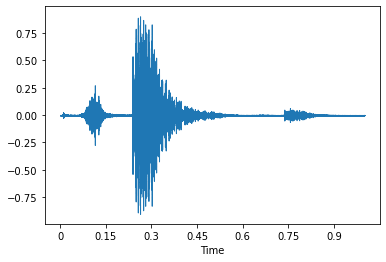

In [14]:
# テストデータを確認
y, fs = librosa.load("TestData/7600.wav", sr=RATE, mono=True)
librosa.display.waveshow(y, sr=RATE)
ipd.Audio(y, rate=RATE)

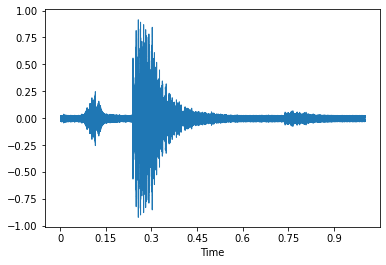

In [15]:
# ノイズを付加したテストデータ
y, fs = librosa.load("TestNoiseData/7600.wav", sr=RATE, mono=True)
librosa.display.waveshow(y, sr=RATE)
ipd.Audio(y, rate=RATE)

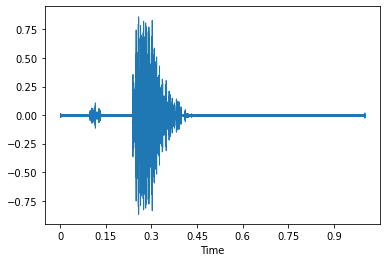

In [16]:
# ノイズを除去したテストデータ
y, fs = librosa.load("ResultData/7600.wav", sr=RATE, mono=True)
librosa.display.waveshow(y, sr=RATE)
ipd.Audio(y, rate=RATE)